# Perform Query and Obtain All Relevant Papers

In [ ]:
import requests
import json
import pandas as pd

In [ ]:
def extract_all(query):
  """
  Function: loops through query to obtain ALL articles (since each request is restricted to 1000 articles at a time)
  - includespaperID, title, authors, abstract, publication, year, and pdf url
  Inputs: query string
  """
  response = requests.get("https://api.semanticscholar.org/graph/v1/paper/search/bulk?query=" + query + "&fields=paperId,title,abstract,venue,year,authors,url,openAccessPdf&sort=publicationDate:desc")
  jsonResponse = response.json()

  data = jsonResponse["data"]
  token = jsonResponse["token"]

  url = "https://api.semanticscholar.org/graph/v1/paper/search/bulk?query=" + query + "&fields=paperId,title,abstract,venue,year,authors,url,openAccessPdf&sort=publicationDate:desc&token="

  while(token != None):
      new_url = url + token
      response = requests.get(new_url)
      r_json = response.json()

      new_data = r_json["data"]
      data = data + new_data

      token = r_json["token"]

  return data

In [ ]:
OR_response = extract_all("(amorphous+MoS3)|MoS3|EXAF")
AND_response = extract_all("amorphous+MoS3+EXAF")

## Obtain Unique Papers

In [ ]:
!pip install "iteration_utilities"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 7.6 MB/s eta 0:00:00


In [ ]:
from iteration_utilities import unique_everseen

data = OR_response + AND_response
unique_data = list(unique_everseen(data))
df = pd.DataFrame(unique_data)
df.shape

(18539, 8)

In [ ]:
df.sample(5)

,paperId,url,title,abstract,venue,year,openAccessPdf,authors
7884,3ba505d7a25b26914b4f31cf6f74af6d36f8c8c2,https://www.semanticscholar.org/paper/3ba505d7...,The structure of lead-silicate glasses: molecu...,Molecular dynamics (MD) simulations and extend...,,2001.0,None,"[{'authorId': '92412530', 'name': 'J. Rybicki'..."
8110,eac639e04c82722d95b823f5665f87accae3f9b6,https://www.semanticscholar.org/paper/eac639e0...,XAFS study of copper species stabilized in the...,New intercalation compounds with Cu2+ ions in ...,Journal of Synchrotron Radiation,2001.0,{'url': 'https://journals.iucr.org/s/issues/20...,"[{'authorId': '24381878', 'name': 'D. Kim'}, {..."
153,8f9ad5da1b0f1f39dec92ec4e6da45956ad8192f,https://www.semanticscholar.org/paper/8f9ad5da...,Layered Quasi-Nevskite Metastable-Phase Cobalt...,Clarifying the structure-reactivity relationsh...,ACS Nano,2024.0,None,"[{'authorId': '1382255140', 'name': 'Zhenglong..."
13586,3a14c3b49242e6bf8f9c7825286a59d6163b0775,https://www.semanticscholar.org/paper/3a14c3b4...,ff ects of rhodium and antimony dopants on the...,The nature and effects of rhodium and antimony...,,2016.0,None,"[{'authorId': '143938191', 'name': 'E. Glover'..."
2920,6a4e9ba9ae44140a93403cf8aac4a3ecf953910f,https://www.semanticscholar.org/paper/6a4e9ba9...,EXAFS study of thermoelectric BiCuOSe: Effects...,None,,2015.0,None,"[{'authorId': '92156827', 'name': 'T. Chou'}, ..."


## Check Missing Values

In [ ]:
missing_prop = df.isna().sum() / len(df.index)
missing_prop.name = 'missing_prop'
missing_prop.sort_values(ascending=False)

,missing_prop
openAccessPdf,0.820864
abstract,0.264739
year,0.007120
paperId,0.000000
url,0.000000
title,0.000000
venue,0.000000
authors,0.000000


## Ranking Text Based on Relevant Words in Title and Abstract

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

title = df['title']
abstract = df['abstract']

# tokenize into words
tokenized_title = title.apply(word_tokenize)
tokenized_abstract = abstract.apply(lambda x: word_tokenize(x) if x != None else x)

# lowercase
tokenized_title = tokenized_title.apply(lambda x: [word.lower() for word in x])
tokenized_abstract = tokenized_abstract.apply(lambda x: [word.lower() for word in x] if x != None else x)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def relWordsScore(title, abstract, relWords):
  '''
  Function: Computes the proportion of relevant Words that are contained within the title and abstract (score is on a 0-1 scale)
  Input: Takes in list of tokenized title words, tokenized abstract words and words of interest
  '''
  score = 0
  for word in relWords:
    if word in title or (abstract != None and word in abstract):
      score += 1
  score = score / len(relWords)
  score = round(score, 2)
  return score

In [ ]:
relevantWords = ['amorphous', 'mos3', 'exafs', 'molybdenum', 'sulfide', 'k-edge']

data = pd.DataFrame({'title': tokenized_title, 'abstract': tokenized_abstract})
relWordScore = data.apply(lambda x: relWordsScore(x.loc['title'], x.loc['abstract'], relevantWords), axis = 1)

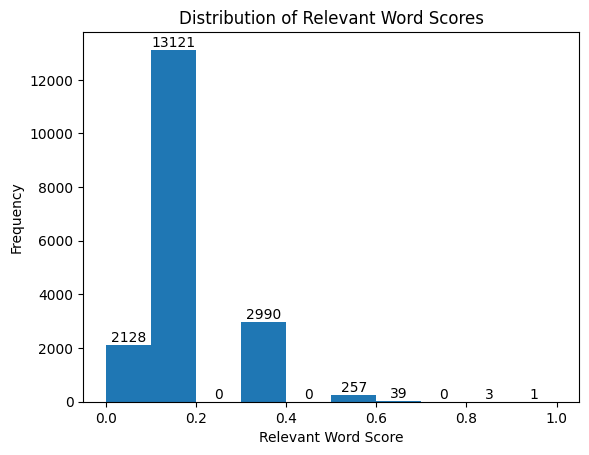

In [ ]:
import matplotlib.pyplot as plt

df['relWordScore'] = relWordScore
df = df.sort_values(by='relWordScore', ascending=False)

# Plot the distribution of relevant word scores
values, bins, bars = plt.hist(df['relWordScore'])
plt.xlabel('Relevant Word Score')
plt.ylabel('Frequency')
plt.title('Distribution of Relevant Word Scores')
plt.bar_label(bars, fontsize=10)
plt.show()

## Download DataFrame as CSV

In [ ]:
df.to_csv('relevantpapers.csv')

# Download Paper PDFs

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import pandas as pd
import time

In [ ]:
# read in semantic scholar urls
df = pd.read_csv('/Users/briannanguyen/Desktop/relevantpapers.csv')
urls = df['url']

In [ ]:
# initiate list of paper links to check again (could not be downloaded or doi was not identified)
checkAgain = []

In [ ]:
# set up chrome driver
PATH = '/Users/briannanguyen/Downloads/chromedriver-mac-x64/chromedriver'

chrome_service = Service(executable_path=PATH)
driver = webdriver.Chrome(service=chrome_service)

In [ ]:
# iterate through each url to download pdf
for url in urls:

    # open webpage
    link = url
    driver.get(link)

    # manually solve captcha if needed
    # input("Press enter after captcha has been completed.")
    time.sleep(2)

    try:
        # get doi link
        search = driver.find_element(By.CLASS_NAME, "doi__link")
        doi = search.get_attribute('href')

        # search doi link for pdf
        driver.get(doi)

        # search for pdf on sci-hub
        scihub = 'https://paperpanda.app/search'
        driver.get(scihub)

        # look for search bar and check paper
        query = driver.find_element(By.ID, "search")
        query.send_keys(doi)
        query.send_keys(Keys.RETURN)

        # manually solve captcha
        # input("Press enter after captcha has been completed.")
        time.sleep(2)

        driver.switch_to.window(driver.window_handles[1])

        # download pdf if available
        try:
            button = driver.find_element(By.XPATH, '/html/body/div[3]/div[1]/button')
            button.click()
        except:
            checkAgain.append(url)
            pass

        # close first tab
        driver.switch_to.window(driver.window_handles[0])
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
        time.sleep(5)

    except:
        checkAgain.append(url)
        pass

In [ ]:
# save url that need to be checked again
#len(checkAgain)
reCheck = pd.DataFrame(checkAgain)
reCheck.to_csv("/Users/briannanguyen/Desktop/reCheck.csv")

# Extract Paper Methdology and Figure Captions

## Text Mining Functions

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 25 20:10:57 2024

@author: gjw123
"""

!pip install openai
!pip install pypdf
!pip install tiktoken

from openai import OpenAI
import openai
import pypdf
import re
import os
import requests
import pandas as pd
import tiktoken
import time
from io import StringIO
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np
import ast
import csv


def count_tokens(text):
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(text))
    return num_tokens


def get_txt_from_pdf(pdf_files, filter_ref=False, combine=False):
    """Convert pdf files to dataframe"""
    data = []
    for pdf in pdf_files:
        with open(pdf, 'rb') as pdf_content:
            pdf_reader = pypdf.PdfReader(pdf_content)
            meta = pdf_reader.metadata
            # print(meta)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.get_page(page_num)
                try:
                    page_text = page.extract_text() # Extract the text from the current page
                    words = page_text.split() # Split the page text into individual words
                    page_text_join = ' '.join(words) # Join the words back together with a single space between each word

                    if filter_ref: # filter the reference at the end
                        page_text_join = remove_ref(page_text_join)

                    page_len = len(page_text_join)
                    div_len = page_len // 4 # Divide the page into 4 parts
                    page_parts = [page_text_join[i*div_len:(i+1)*div_len] for i in range(4)]

                    min_tokens = 40
                    for i, page_part in enumerate(page_parts):
                        if count_tokens(page_part) > min_tokens:
                            # Append the data to the list
                            data.append({
                                'file name': pdf,
                                'page number': page_num + 1,
                                'page section': i+1,
                                'content': page_part,
                                'doi': meta.get('/prism:doi'),
                                'tokens': count_tokens(page_part)
                            })
                except:
                    print(pdf, page_num)
                    break

    df = pd.DataFrame(data)
    if combine:
        df = combine_section(df)
    return df


def remove_ref(pdf_text):
    """This function removes reference section from a given PDF text. It uses regular expressions to find the index of the words to be filtered out."""
    # Regular expression pattern for the words to be filtered out
    pattern = r'(REFERENCES|Acknowledgment|ACKNOWLEDGMENT)'
    match = re.search(pattern, pdf_text)

    if match:
        # If a match is found, remove everything after the match
        start_index = match.start()
        clean_text = pdf_text[:start_index].strip()
    else:
        # Define a list of regular expression patterns for references
        reference_patterns = [
            '\[[\d\w]{1,3}\].+?[\d]{3,5}\.','\[[\d\w]{1,3}\].+?[\d]{3,5};','\([\d\w]{1,3}\).+?[\d]{3,5}\.','\[[\d\w]{1,3}\].+?[\d]{3,5},',
            '\([\d\w]{1,3}\).+?[\d]{3,5},','\[[\d\w]{1,3}\].+?[\d]{3,5}','[\d\w]{1,3}\).+?[\d]{3,5}\.','[\d\w]{1,3}\).+?[\d]{3,5}',
            '\([\d\w]{1,3}\).+?[\d]{3,5}','^[\w\d,\.– ;)-]+$',
        ]

        # Find and remove matches with the first eight patterns
        for pattern in reference_patterns[:8]:
            matches = re.findall(pattern, pdf_text, flags=re.S)
            pdf_text = re.sub(pattern, '', pdf_text) if len(matches) > 500 and matches.count('.') < 2 and matches.count(',') < 2 and not matches[-1].isdigit() else pdf_text

        # Split the text into lines
        lines = pdf_text.split('\n')

        # Strip each line and remove matches with the last two patterns
        for i, line in enumerate(lines):
            lines[i] = line.strip()
            for pattern in reference_patterns[7:]:
                matches = re.findall(pattern, lines[i])
                lines[i] = re.sub(pattern, '', lines[i]) if len(matches) > 500 and len(re.findall('\d', matches)) < 8 and len(set(matches)) > 10 and matches.count(',') < 2 and len(matches) > 20 else lines[i]

        # Join the lines back together, excluding any empty lines
        clean_text = '\n'.join([line for line in lines if line])

    return clean_text


def combine_section(df):
    """Merge sections, page numbers, add up content, and tokens based on the pdf name."""
    aggregated_df = df.groupby('file name').agg({
        'content': aggregate_content,
        'tokens': aggregate_tokens
    }).reset_index()

    return aggregated_df


def aggregate_content(series):
    """Join all elements in the series with a space separator. """
    return ' '.join(series)


def aggregate_tokens(series):
    """Sum all elements in the series."""
    return series.sum()


def extract_title(file_name):
    """Extract the main part of the file name. """
    title = file_name.split('_')[0]
    return title.rstrip('.pdf')


def combine_main_SI(df):
    """Create a new column with the main part of the file name, group the DataFrame by the new column,
    and aggregate the content and tokens."""
    df['main_part'] = df['file name'].apply(extract_title)
    merged_df = df.groupby('main_part').agg({
        'content': ''.join,
        'tokens': sum
    }).reset_index()

    return merged_df.rename(columns={'main_part': 'file name'})


def df_to_csv(df, file_name):
    """Write a DataFrame to a CSV file."""
    df.to_csv(file_name, index=False, escapechar='\\')


def csv_to_df(file_name):
    """Read a CSV file into a DataFrame."""
    return pd.read_csv(file_name)



def tabulate_condition(df, column_name):
    """This function converts the text from a ChatGPT conversation into a DataFrame.
    It also cleans the DataFrame by dropping additional headers and empty lines.    """

    table_text = df[column_name].str.cat(sep='\n')

    # Remove leading and trailing whitespace
    table_text = table_text.strip()

    # Split the table into rows
    rows = table_text.split('\n')

    # Extract the header row and the divider row
    header_row, divider_row, *data_rows = rows

    # Extract column names from the header row

    column_names = ['compound name', 'metal source', 'metal amount', 'linker', 'linker amount',
                   'modulator', 'modulator amount or volume', 'solvent', 'solvent volume', 'reaction temperature',
                   'reaction time']

    # Create a list of dictionaries to store the table data
    data = []

    # Process each data row
    for row in data_rows:

        # Split the row into columns
        columns = [col.strip() for col in row.split('|') if col.strip()]

        # Create a dictionary to store the row data
        row_data = {col_name: col_value for col_name, col_value in zip(column_names, columns)}

        # Append the dictionary to the data list
        data.append(row_data)

    df = pd.DataFrame(data)


    """Make df clean by drop additional header and empty lines """
    def contains_pattern(s, patterns):
        return any(re.search(p, s) for p in patterns)

    def drop_rows_with_patterns(df, column_name):
        #empty cells, N/A cells and header cells
        patterns = [r'^\s*$', r'--',r'-\s-', r'compound', r'Compound',r'Compound name', r'Compound Name',
                r'NaN',r'N/A',r'n/a',r'\nN/A', r'note', r'Note']

        mask = df[column_name].apply(lambda x: not contains_pattern(str(x), patterns))
        filtered_df = df[mask]

        return filtered_df


    #drop the repeated header
    df = drop_rows_with_patterns(df, 'compound name')

    #drop the organic synthesis (where the metal source is N/a)
    filtered_df = drop_rows_with_patterns(drop_rows_with_patterns(drop_rows_with_patterns(df,'metal source'),'metal amount'),'linker amount')

    #drop the N/A rows
    filtered_df = filtered_df.dropna(subset=['metal source','metal amount', 'linker amount'])

    return filtered_df



def split_content(input_string, tokens):
    """Splits a string into chunks based on a maximum token count. """

    MAX_TOKENS = tokens
    split_strings = []
    current_string = ""
    tokens_so_far = 0

    for word in input_string.split():
        # Check if adding the next word would exceed the max token limit
        if tokens_so_far + count_tokens(word) > MAX_TOKENS:
            # If we've reached the max tokens, look for the last dot or newline in the current string
            last_dot = current_string.rfind(".")
            last_newline = current_string.rfind("\n")

            # Find the index to cut the current string
            cut_index = max(last_dot, last_newline)

            # If there's no dot or newline, we'll just cut at the max tokens
            if cut_index == -1:
                cut_index = MAX_TOKENS

            # Add the substring to the result list and reset the current string and tokens_so_far
            split_strings.append(current_string[:cut_index + 1].strip())
            current_string = current_string[cut_index + 1:].strip()
            tokens_so_far = count_tokens(current_string)

        # Add the current word to the current string and update the token count
        current_string += " " + word
        tokens_so_far += count_tokens(word)

    # Add the remaining current string to the result list
    split_strings.append(current_string.strip())

    return split_strings


def table_text_clean(text):
    """Cleans the table string and splits it into lines."""

    # Pattern to find table starts
    pattern = r"\|\s*compound\s*.*"

    # Use re.finditer() to find all instances of the pattern in the string and their starting indexes
    matches = [match.start() for match in re.finditer(pattern, text, flags=re.IGNORECASE)]

    # Count the number of matches
    num_matches = len(matches)

    # Base table string
    table_string = """| compound name | metal source | metal amount | linker | linker amount | modulator | modulator amount or volume | solvent | solvent volume | reaction temperature | reaction time |\n|---------------|-------|--------------|--------|---------------|-----------|---------------------------|---------|----------------|---------------------|---------------|\n"""

    if num_matches == 0:  # No table in the answer
        print("No table found in the text: " + text)
        splited_text = ''

    else:  # Split the text based on header
        splited_text = ''
        for i in range(num_matches):
            # Get the relevant table slice
            splited = text[matches[i]:matches[i + 1]] if i != (num_matches - 1) else text[matches[i]:]

            # Remove the text after last '|'
            last_pipe_index = splited.rfind('|')
            splited = splited[:last_pipe_index + 1]

            # Remove the header and \------\
            pattern_dash = r"-(\s*)\|"
            match = max(re.finditer(pattern_dash, splited), default=None, key=lambda x: x.start())

            if not match:
                print("'-|' pattern not found.")
            else:
                first_pipe_index = match.start()
                splited = '\n' + splited[(first_pipe_index + len('-|\n|') - 1):]  # Start from "\"

            splited_text += splited

    table_string = table_string + splited_text
    return table_string

def add_similarity(df, given_embedding):
    """Adds a 'similarity' column to a dataframe based on cosine similarity with a given embedding."""
    def calculate_similarity(embedding):
        # Check if embedding is a string and convert it to a list of floats if necessary
        if isinstance(embedding, str):
            embedding = [float(x) for x in embedding.strip('[]').split(',')]
        return cosine_similarity([embedding], [given_embedding])[0][0]

    df['similarity'] = df['embedding'].apply(calculate_similarity)
    return df


def select_top_neighbors(df):
    """Retains top-10 similarity sections and their neighbors in the dataframe and drops the rest."""
    # Sort dataframe by 'file name' and 'similarity' in descending order
    df.sort_values(['file name', 'similarity'], ascending=[True, False], inplace=True)

    # Group dataframe by 'file name' and select the top 10 rows based on similarity
    top_10 = df.groupby('file name').head(10)

    # Add neighboring rows (one above and one below) to the selection
    neighbors = [i for index in top_10.index for i in (index - 1, index + 1) if 0 <= i < df.shape[0]]

    # Create a new dataframe with only the selected rows
    selected_df = df.loc[top_10.index.union(neighbors)]
    return selected_df


def add_emb(df, api_key):
    """Adds an 'embedding' column to a dataframe using OpenAI API."""
    openai.api_key = api_key
    if 'embedding' in df.columns:
        print('The dataframe already has embeddings. Please double check.')
        return df

    embed_msgs = []
    for _, row in df.iterrows():
        context = row['content']
        context_emb = openai.Embedding.create(model="text-embedding-3-large", input=context)
        embed_msgs.append(context_emb['data'][0]['embedding'])

    df = df.copy()
    df.loc[:, 'embedding'] = embed_msgs

    return df



def model_1(df):
    """Model 1 will turn text in dataframe to a summarized reaction condition table.The dataframe should have a column "file name" and a column "exp content"."""
    response_msgs = []

    for index, row in df.iterrows():
        column1_value = row[df.columns[0]]
        column2_value = row['content']

        max_tokens = 3000 # split text into smaller sections
        if count_tokens(column2_value) > max_tokens:
            context_list = split_content(column2_value, max_tokens)
        else:
            context_list = [column2_value]

        answers = ''  # Collect answers from chatGPT
        for context in context_list: # loop through all sections
            print("Start to analyze paper " + str(column1_value) )
            user_heading = f"This is an experimental section on intermetallic synthesis from paper {column1_value}\n\nContext:\n{context}"
            user_ending = """Q: Can you summarize the following details in a table:
            compound name or chemical formula (if the name is not provided), metal source, metal amount, organic linker(s),
            linker amount, modulator, modulator amount or volume, solvent(s), solvent volume(s), reaction temperature,
            and reaction time? If any information is not provided or you are unsure, use "N/A".
            Please focus on extracting experimental conditions from only the MOF synthesis and ignore information related to organic linker synthesis,
            MOF postsynthetic modification, high throughput (HT) experiment details or catalysis reactions.
            If multiple conditions are provided for the same compound, use multiple rows to represent them. If multiple units or components are provided for the same factor (e.g.  g and mol for the weight, multiple linker or metals, multiple temperature and reaction time, mixed solvents, etc), include them in the same cell and separate by comma.
            The table should have 11 columns, all in lowercase:
            | compound name | metal source | metal amount | linker | linker amount | modulator | modulator amount or volume | solvent | solvent volume | reaction temperature | reaction time |

            A:"""

            attempts = 3
            while attempts > 0:
                try:
                    response = openai.ChatCompletion.create(
                        model='gpt-3.5-turbo',
                        messages=[{
                            "role": "system",
                            "content": """Answer the question as truthfully as possible using the provided context,
                                        and if the answer is not contained within the text below, say "N/A" """
                        },
                            {"role": "user", "content": user_heading + user_ending}]
                    ) # ask chat gpt a promp
                    answer_str = response.choices[0].message.content # store response from chatgpt
                    if not answer_str.lower().startswith("n/a"): # check if answer is contained in the text
                        answers += '\n' + answer_str # if it is, add the answer
                    break
                except Exception as e:
                    attempts -= 1
                    if attempts <= 0:
                        print(f"Error: Failed to process paper {column1_value}. Skipping. (model 1)")
                        break
                    print(f"Error: {str(e)}. Retrying in 60 seconds. {attempts} attempts remaining. (model 1)")
                    time.sleep(60)

        response_msgs.append(answers) # list of answers for each section
    df = df.copy()
    df.loc[:, 'summarized'] = response_msgs # add answers to dataframe
    return df


def model_2(df, api_key):
    """Model 2 has two parts. First, it asks ChatGPT to identify the experiment section,
    then it combines the results"""
    openai.api_key = api_key

    response_msgs = []

    prev_paper_name = None  # Initialize the variable. For message printing purpose
    total_pages = df.groupby(df.columns[0])[df.columns[1]].max() #  For message printing purpose

    for _, row in df.iterrows(): # iterate through each row, keeping iterator + row data
        paper_name = row[df.columns[0]]
        page_number = row[df.columns[1]]
        # Only print the message when the paper name changes
        if paper_name != prev_paper_name:
            print(f'Processing paper: {paper_name}. Total pages: {total_pages[paper_name]}')
            prev_paper_name = paper_name

        context = row['content']  # data from paper

        user_msg1 = """
        Context:
        In a 4-mL scintillation vial, the linker H2PZVDC (91.0 mg, 0.5 mmol, 1 equiv.) was dissolved in N,N-dimethylformamide (DMF) (0.6 mL) upon sonication. An aqueous solution of AlCl3·6H2O (2.4 mL, 0.2 M, 1 equiv.) was added dropwise, and the resulting mixture was heated in a 120 °C oven for 24 hours.
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: Yes.

        Context:
        These metal salt mixtures were combined with 18 mg of H4DOT and then dissolved in a mixture of DMF (6 mL), EtOH (0.36 mL), and water (0.36 mL). The reaction mixture was heated to specific temperatures (120°C or 85°C) for 24 h.
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: Yes.

        Context:
        Synthesis of MOF-5.19 Zn(NO3)2?4H2O (31.824 mmol) and H2bdc (10.594 mmol) were dissolved in DEF (100 cm3). The solution was heated to 100 C.
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: Yes.

        Context:
        [Zr6O4(OH)8(H2O)4(CTTA)8/3]·S (BUT-12·S). ZrCl4 (48 mg), H3CTTA (40 mg), and formic acid (8 mL) were ultrasonically dissolved in N,N′-dimethylformamide (DMF, 8 mL) in a 20 mL Pyrexvial.
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: Yes.

        Context:
        A 0.150 M solution of imidazole in DMF and a 0.075M solution of Zn(NO3)2·4H2O in DMF were used as stock solutions, and heated in a 85 ºC isothermal oven for 3 days.
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: Yes.

        Context:
        Synthesis and Characterization of MOFs, Abbreviations, and General Procedures. For easy reference, the formulas for MOF-69-80, explanation of guest abbreviations and organic carboxylates, andcrystal unit cell parameters are listed in Table 2. Unless otherwiseindicated, chemicals were purchased from the Aldrich Chemical Co.and used as received. HPDC and ATC organic linkers were synthesizedaccording to published procedures.13 HPDC was protected, dehydrogenated, and then deprotected to yield PDC.14
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: No.

        Context:
        The design and synthesis of metal-organic frameworks (MOFs) has yielded a large number of structures which have been shown to have useful gas and liquid adsorption properties.1In particular, porous structures constructed from discrete metalcarboxylate clusters and organic links have been shown to beamenable to systematic variation in pore size and functionality.
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: No.

        Context:
        Solvothermal reactions of Co(NO3)·6H2O, Hatz, and L1/L2 in a 2:2:1 molar ratio in DMF solvent at 180 °C for 24 h yielded
        two crystalline products, 1 and 2, respectively
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: No.

        Context:
        A 22.9% weight loss was observed from 115 to 350 °C, which corresponds to the loss of one DEF molecule per formula unit (calcd: 23.5%).
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer: No.

        Context:
          """

        user_msg2 = """
        Question: Does the section contain a comprehensive MOF synthesis with explicit reactant quantities or solvent volumes?
        Answer:
        """

        attempts = 3
        while attempts > 0:
            try:
                response = openai.ChatCompletion.create(
                    model='gpt-3.5-turbo',
                    messages=[
                        {"role": "system", "content": "Determine if the section comes from an experimental section for MOF synthesis, which contains information on at least one of the following: reaction time, reaction temperature, metal source, organic linker, the amount, solvent and volume. Answer will be either Yes or No."},
                        {"role": "user", "content": user_msg1 + context + user_msg2}
                    ]
                )
                answers = response.choices[0].message.content
                break

            except Exception as e:
                attempts -= 1
                if attempts > 0:
                    print(f"Error: {str(e)}. Retrying in 60 seconds. {attempts} attempts remaining. (model 2)")
                    time.sleep(60)
                else:
                    print(f"Error: Failed to process paper {paper_name}. Skipping. (model 2)")
                    answers = "No"
                    break

        response_msgs.append(answers)
    df = df.copy()
    df.loc[:,'classification'] = response_msgs # probably will not need this code


    # The following section creates a new dataframe after applying some transformations to the old dataframe
    # Create a boolean mask for rows where 'results' starts with 'No'
    mask_no = df["classification"].str.startswith("No")
    # Create a boolean mask for rows where both the row above and below have 'No' in the 'results' column
    mask_surrounded_by_no = mask_no.shift(1, fill_value=False) & mask_no.shift(-1, fill_value=False)
    # Combine the two masks with an AND operation
    mask_to_remove = mask_no & mask_surrounded_by_no
    # Invert the mask and filter the DataFrame
    filtered_df = df[~mask_to_remove]
    #combined
    combined_df= combine_main_SI(combine_section(filtered_df ))
    #call model 1 to summarized results
    add_table_df = model_1(combined_df)
    return add_table_df


def model_3(df, api_key, prompt_choice="synthesis", classfication=True):
    """Input a dataframe in broken separation, ~300 tokens, separated by pages and sections. This function will filter the unnecessary sections."""

    # Set up your API key
    openai.api_key = api_key
    prompt = "What is the synthesis condition of PdCu intermetallic?"

    """
    # Define the prompt
    prompts = {
        "synthesis": "The synthesis condition of PdCu intermetallic can vary depending on the desired properties of the material. However, common methods for synthesizing PdCu intermetallics include:",
        "TGA": "Identify the section discussing thermogravimetric analysis (TGA) and thermal stability. This section typically includes information about weight-loss steps (e.g., 20%, 30%, 29.5%) and a decomposition temperature range (e.g., 450°C, 515°C) or a plateau.",
        "sorption": "Identify the section discussing nitrogen (N2) sorption, argon sorption, Brunauer-Emmett-Teller (BET) surface area, Langmuir surface area, and porosity. This section typically reports values such as 1000 m2/g, 100 cm3/g STP, and includes pore diameter or pore size expressed in units of Ångströms (Å)"
    }

    #other than "synthesis", "TGA", "sorption"),the prompt choice can be the name of the linker to be searched for.
    # If the choice is not one of the predefined ones ("synthesis", "TGA", "sorption"), it defaults to a generic prompt for the linker.
    prompt = prompts.get(prompt_choice, f"Provide the full name of linker ({prompt_choice}) or denoted as {prompt_choice} in chemicals, abstract, introduction or experimental section.")
    """

    # Create an embedding for the chosen prompt using OpenAI's embedding model
    prompt_result = openai.Embedding.create(model="text-embedding-3-large", input=prompt)
    # Extract the embedding data from the result
    prompt_emb = prompt_result['data'][0]['embedding']

    # If the dataframe does not already have an 'embedding' column, add one. This is done by calling the add_emb function on the dataframe
    if 'embedding' not in df.columns:
        df_with_emb = add_emb(df)
    else:
        df_with_emb  = df

    # Add a 'similarity' column to the dataframe by comparing the embeddings.This is done by calling the add_similarity function on the dataframe and the prompt embedding
    df_2 = add_similarity(df_with_emb, prompt_emb)

    # Filter the dataframe to only include rows with top similarity and their neighbors
    df_3 = select_top_neighbors(df_2)

    # If the classification parameter is True, pass the dataframe to model_2 for further processing
    if classfication:
        return model_2(df_3, api_key)

    # If the classification parameter is False, return the filtered dataframe as is
    return df_3


################################################################################
def load_paper(filename):
    """Crate a dataframe"""
    if os.path.exists(filename):
        dataframe = pd.read_csv(filename)
        return dataframe
    else:
        #load pdf names

        with open('pdf_pool.csv', 'r') as file:
            reader = csv.reader(file)
            pdf_pool = [row[0] for row in reader]
        dataframe = get_txt_from_pdf(pdf_pool,combine = False, filter_ref = True)

        #store the dataframe
        df_to_csv(dataframe, filename)


def load_paper_emb(filename):
    """Crate a dataframe that includes embedding information"""
    if os.path.exists(filename):
        paper_df_emb  = pd.read_csv(filename)
        paper_df_emb['embedding'] = paper_df_emb['embedding'].apply(ast.literal_eval)

    else: #load paper and create embedding
        paper_df_emb = add_emb(load_paper())
    #store embedding to csv
        df_to_csv(paper_df_emb, filename)

    return paper_df_emb


def check_system(syn_df, paper_df, paper_df_emb):
    """Check if the data is correctly loaded"""
    # check if openai.api_key is not placeholder
    if openai.api_key  == "Add Your OpenAI API KEY Here.":
        print("Error: Please replace openai.api_key with your actual key.")
        return False

    # check if 'content' column exists in syn_df
    if 'content' not in syn_df.columns:
        print("Error: 'content' column is missing in syn_df.")
        return False

    # check if 'paper_df' has at least four columns
    expected_columns = ['file name', 'page number', 'page section', 'content']
    if not all(col in paper_df.columns for col in expected_columns):
        print("Error: 'paper_df' should have these columns: 'file name', 'page number', 'page section', 'content'.")
        return False

    # check if 'embedding' column exists in paper_df_emb
    if 'embedding' not in paper_df_emb.columns:
        print("Error: 'embedding' column is missing in paper_df_emb.")
        return False

    print("All checks passed.")
    return True

In [ ]:
# Access Directory of Downloaded Papers
from google.colab import drive
from pathlib import Path
import glob

drive.mount('/content/drive')
directory = "/content/drive/MyDrive/Digital Synthesis Lab/Text Mining/Code/Downloaded Papers (n=123)"

## Extract Text, Methodology and Figure Captions

In [ ]:
from google.colab import drive
from pathlib import Path
import glob

drive.mount('/content/drive')
directory = "/content/drive/MyDrive/Digital Synthesis Lab/Text Mining/Code/Downloaded Papers (n=123)"

In [ ]:
def extractRelevantText(df):
    '''
    Takes in dataframe consisting of paper name and text and outputs new dataframe with methodology, relevant text and figure captions
    '''
    openai.api_key = "...."
    client = OpenAI(api_key=openai.api_key)

    response_msgs = []
    df = df.copy()

    for index, row in df.iterrows(): # iterate through each paper
        column1_value = row[df.columns[0]]
        column2_value = row['content']

        max_tokens = 10000 # split text into smaller sections
        if count_tokens(column2_value) > max_tokens:
            context_list = split_content(column2_value, max_tokens)
        else:
            context_list = [column2_value]

        methodologyAnswer = ''
        figureCaptionsAnswer = ''
        # relevantTextAnswer = ''

        for context in context_list: # loop through all sections
            #print("Start to analyze paper " + str(column1_value) )

            user_heading = f"This is the full text content from paper {column1_value}\n\nContext:\n{context}"
            user_ending1 = "Identify and give the text from the methods or experimental section. Else, say N/A"
            user_ending2 = "Identify and give a list of all figure captions. Else, say N/A"
            # user_ending3 = "Identify and list all relevant text related to amorphous synthesis, MoS3, EXAFs. Else, say N/A"

            attempts = 3
            while attempts > 0:
                try:
                    methodology = client.chat.completions.create( # extract methods/experimental section
                      model="gpt-3.5-turbo",
                      messages=[
                      {"role": "user", "content": user_heading + user_ending1}])

                    figureCaptions = client.chat.completions.create( # extract all figure captions from the text
                      model="gpt-3.5-turbo",
                      messages=[
                        {"role": "user", "content": user_heading + user_ending2}])

                    # relevantText = client.chat.completions.create( # extract all relevant text
                    #   model="gpt-4o",
                    #   messages=[{
                    #     "role": "system",
                    #     "content": """Answer the question as truthfully as possible using the provided context,
                    #     and if the answer is not contained within the text below, say "N/A" """},
                    #     {"role": "user", "content": user_heading + user_ending3}])

                    methodology_str = methodology.choices[0].message.content
                    figureCaptions_str = figureCaptions.choices[0].message.content
                    # relevantText_str = relevantText.choices[0].message.content # store response from chatgpt

                    if not methodology_str.lower().startswith("n/a"):
                        methodologyAnswer += '\n' + methodology_str
                    if not figureCaptions_str.lower().startswith("n/a"):
                        figureCaptionsAnswer += '\n' + figureCaptions_str
                    # if not relevantText_str.lower().startswith("n/a"):
                    #     relevantTextAnswer += '\n' + relevantText_str
                    break
                except Exception as e:
                    attempts -= 1
                    if attempts <= 0:
                        print(f"Error: Failed to process paper {column1_value}. Skipping. (model 1)")
                        break
                    print(f"Error: {str(e)}. Retrying in 60 seconds. {attempts} attempts remaining. (model 1)")
                    time.sleep(60)

            df.loc[index, 'methods'] = methodologyAnswer
            df.loc[index, 'figureCaptions'] = figureCaptionsAnswer
            # df.loc[index, 'relevantText'] = relevantTextAnswer

    return df

In [ ]:
df = extractRelevantText(df)
df.sample(5)

In [ ]:
import re
cleaned_df = df.replace({'\n': ''}, regex=True)

In [ ]:
# extract only file name, methods and figure data
figureMethods = cleaned_df[['file name', 'methods', 'figureCaptions']]
#figureMethods.loc[:, 'file name'] = figureMethods.loc[:, 'file name'].astype(str)
#figureMethods.loc[:, 'file name'] = figureMethods.loc[:, 'file name'].str[88:]
figureMethods.sample(5)

In [ ]:
containsText = figureMethods
containsText.loc[:,'figureCaptions'] = containsText.loc[:,'figureCaptions'].str.lower()

In [ ]:
# Filter papers with figures that contains MoS and EXAFs
index1 = containsText['figureCaptions'].str.contains('mos')
index2 = containsText['figureCaptions'].str.contains('exafs')

index1 = index1 & index2

filteredfigureMethods = figureMethods[index1]

In [ ]:
# save dataframe
filteredfigureMethods.to_csv('figureMethodsFilteredPapers.csv', index=False, escapechar='\\')

# Download Figure Images

In [ ]:
!pip install fitz
!pip install PyMuPDF

In [ ]:
import fitz
import os
from PIL import Image
import pandas as pd

filteredfigureMethods = pd.read_csv('/content/figureMethodsFilteredPapers.csv')
paths = filteredfigureMethods['file name']

In [ ]:
sample = "/content/drive/MyDrive/Digital Synthesis Lab/Text Mining/Code/Figure Filtered Papers (n=23)/30_380.pdf"
pdf_file = fitz.open(sample)

for pageNum in range(pdf_file.page_count):
  page = pdf_file.load_page(pageNum)

  image_list = page.get_images()

  for index, image in enumerate(image_list):
    xref = image[0]
    base_image = pdf_file.extract_image(xref)

    image_file = f"page{pageNum}-image{index}.jpg"

    with open(image_file, "wb") as image_file:
      image_file.write(base_image["image"])